In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from skimage.color import rgb2lab
import cv2
from PIL import Image
from tqdm import tqdm

In [37]:
def compute_asymmetry(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape
    left = gray[:, :w//2]
    right = np.fliplr(gray[:, w//2:])
    right = cv2.resize(right, (left.shape[1], left.shape[0]))
    diff = cv2.absdiff(left, right)
    return np.mean(diff) / 255

In [38]:
def compute_border_irregularity(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return 0
    cnt = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    if area == 0:
        return 0
    return (perimeter ** 2) / (4 * np.pi * area)

In [39]:
def compute_color_variance(image):
    lab = rgb2lab(image / 255.0)
    return np.mean([np.std(lab[..., 0]), np.std(lab[..., 1]), np.std(lab[..., 2])])

In [40]:
def process_images(image_folder, image_names):
    data = []
    for name in tqdm(image_names):
        path = os.path.join(image_folder, f"{name}.jpg")
        try:
            img = Image.open(path).convert("RGB").resize((224, 224))
            img_np = np.array(img)
            asym = compute_asymmetry(img_np)
            border = compute_border_irregularity(img_np)
            color = compute_color_variance(img_np)
            data.append([name, asym, border, color])
        except:
            data.append([name, None, None, None])
    return pd.DataFrame(data, columns=["image_name", "asymmetry", "border_irregularity", "color_variation"])

In [41]:
image_dir = 'ISIC_2020_Training_JPEG/train'
labels_path = 'ISIC_2020_Training_GroundTruth.csv'

labels_df = pd.read_csv(labels_path)
labels_df['image_path'] = labels_df['image_name'].apply(lambda x: os.path.join(image_dir, f"{x}.jpg"))
labels_df = labels_df[labels_df['image_path'].apply(os.path.exists)]
labels_df['target'] = labels_df['target'].astype(int)

# abc_df = process_images(image_dir, labels_df['image_name'].tolist())
# full_df = pd.merge(labels_df, abc_df, on='image_name')
# full_df.to_csv('ISIC_2020_with_ABC.csv', index=False)
full_df = pd.read_csv('ISIC_2020_with_ABC.csv')

In [42]:
n_malignant = len(full_df[full_df['target'] == 1])
n_benign = len(full_df[full_df['target'] == 0])
n_benign_sample = min(n_malignant * 3, n_benign)

In [43]:
malignant_df = full_df[full_df['target'] == 1]
benign_df = full_df[full_df['target'] == 0].sample(n=n_benign_sample, random_state=42)

In [44]:
balanced_df = pd.concat([malignant_df, benign_df]).sample(frac=1, random_state=42)

In [45]:
# train_df, temp_df = train_test_split(balanced_df, test_size=0.4, stratify=balanced_df['target'], random_state=42)
# val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['target'], random_state=42)

# train_df.to_csv('train_with_abc.csv', index=False)
# val_df.to_csv('val_with_abc.csv', index=False)
# test_df.to_csv('test_with_abc.csv', index=False)

,Data Type,Unique Values
image_name,object,1401
patient_id,object,905
sex,object,2
age_approx,float64,16
anatom_site_general_challenge,object,6
diagnosis,object,6
benign_malignant,object,2
target,int64,2
image_path,object,1401
asymmetry,float64,1400


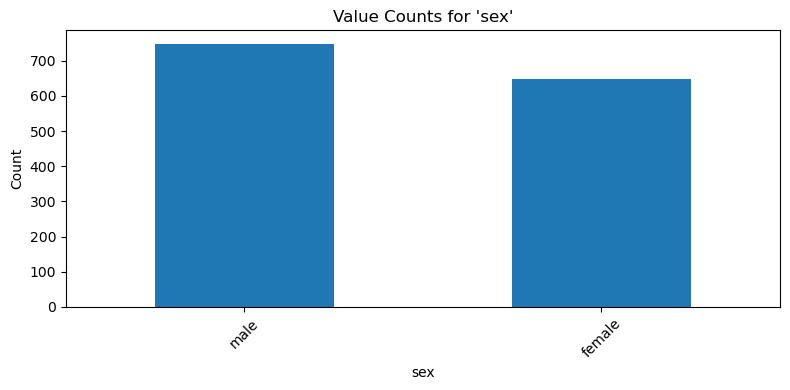

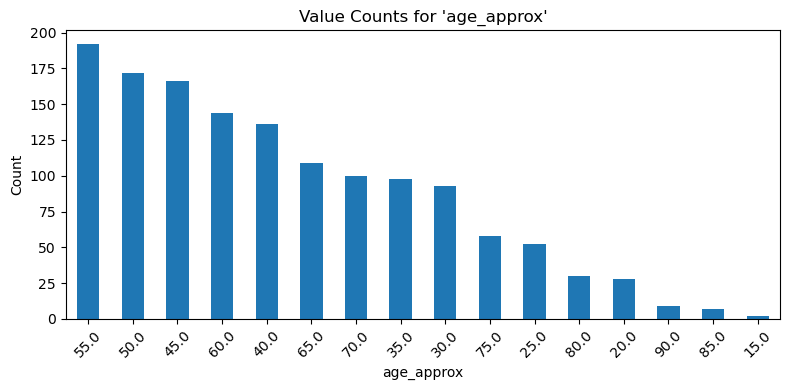

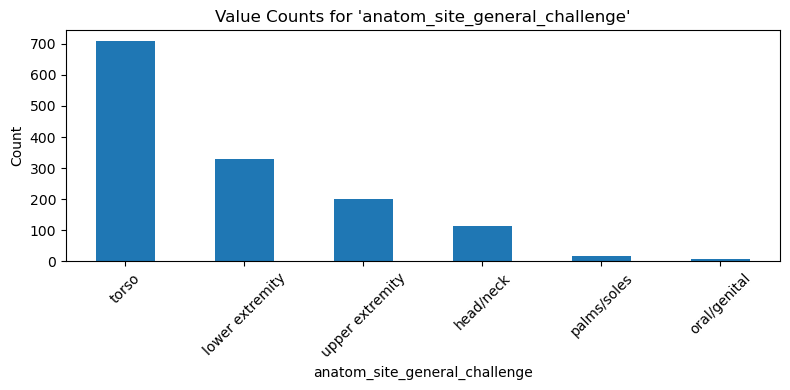

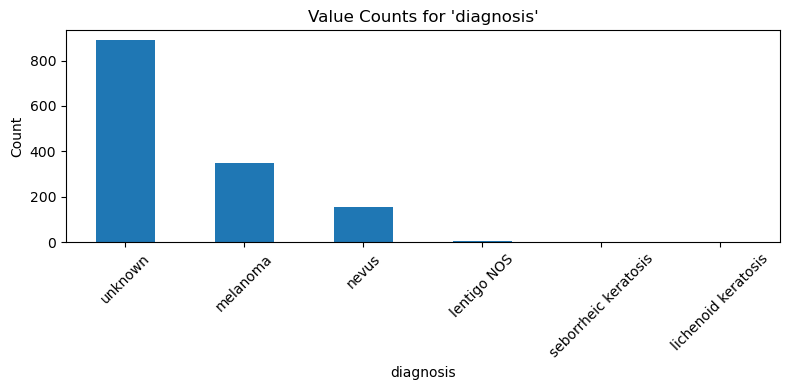

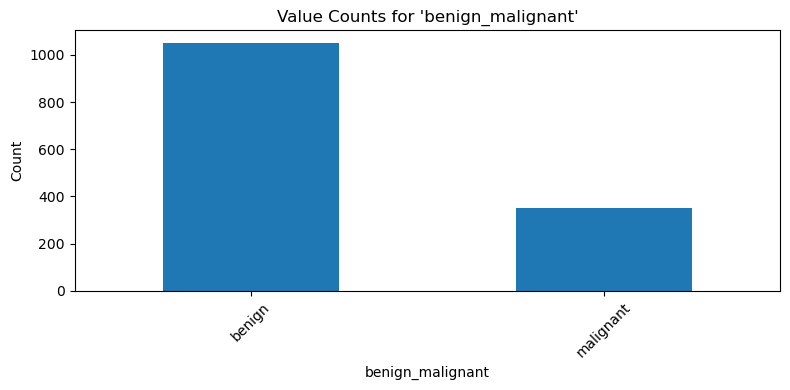

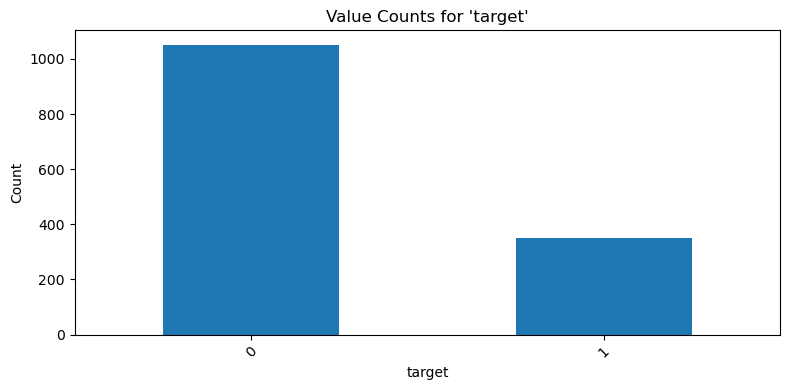

In [46]:
df=pd.read_csv('train_with_abc.csv')

summary = pd.DataFrame({
    'Data Type': df.dtypes,
    'Unique Values': df.nunique()
})
display(summary)

exclude_cols = ['image_name', 'patient_id','image_path']

for col in df.columns:
    if col not in exclude_cols and (df[col].dtype == 'object' or df[col].nunique() < 100):
        plt.figure(figsize=(8, 4))
        df[col].value_counts().plot(kind='bar')
        plt.title(f"Value Counts for '{col}'")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

In [47]:
cross_tab = pd.crosstab(df['diagnosis'], df['target'])

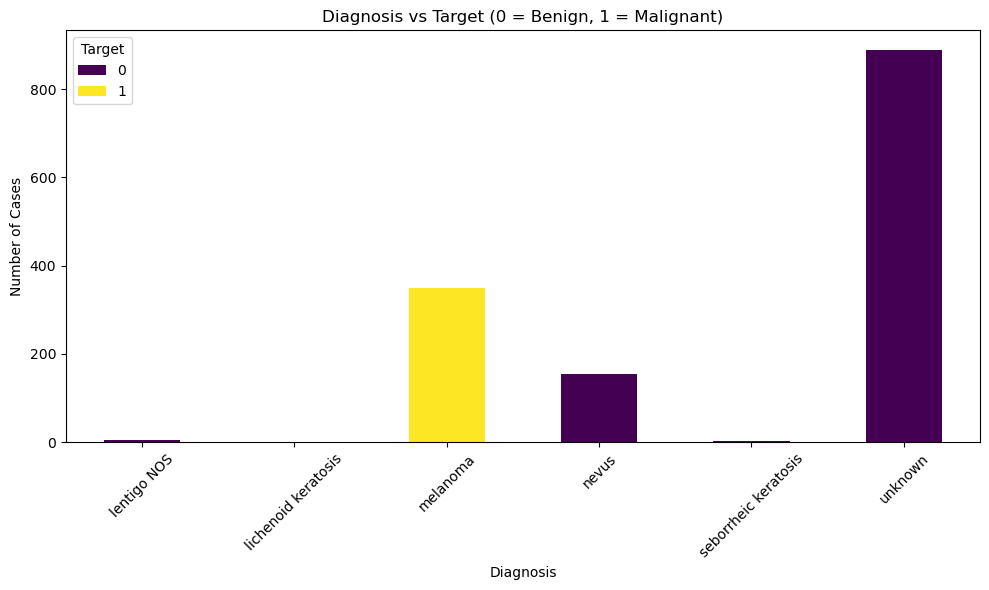

In [48]:
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis')
plt.title("Diagnosis vs Target (0 = Benign, 1 = Malignant)")
plt.xlabel("Diagnosis")
plt.ylabel("Number of Cases")
plt.xticks(rotation=45)
plt.legend(title="Target")
plt.tight_layout()
plt.show()

In [49]:
train_df = pd.read_csv('train_with_abc.csv')
val_df = pd.read_csv('val_with_abc.csv')

train_df['target'] = train_df['target'].astype(str)
val_df['target'] = val_df['target'].astype(str)

In [50]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# IMG_SIZE = 224
# BATCH_SIZE = 32

# train_datagen = ImageDataGenerator(
#     rescale=1./255,
#     rotation_range=20,
#     zoom_range=0.2,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# val_datagen = ImageDataGenerator(rescale=1./255)

# train_gen = train_datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory='ISIC_2020_Training_JPEG/train',
#     x_col='image_name',  # ✅ Not 'image_path'
#     y_col='target',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode='binary',
#     batch_size=BATCH_SIZE
# )

# val_gen = val_datagen.flow_from_dataframe(
#     dataframe=val_df,
#     directory='ISIC_2020_Training_JPEG/train',
#     x_col='image_name',
#     y_col='target',
#     target_size=(IMG_SIZE, IMG_SIZE),
#     class_mode='binary',
#     batch_size=BATCH_SIZE
# )


In [51]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
!unzip ISIC_2020_Training_JPEG.zip

In [52]:
IMG_DIR     = 'ISIC_2020_Training_JPEG/train'
ABC_FEATURES  = ['asymmetry', 'border_irregularity', 'color_variation']
IMG_SIZE      = 224
BATCH_SIZE    = 32

In [56]:
def load_images(df, IMG_DIR):
    images = []
    for name in df['image_name']:
        path = f"{IMG_DIR}/{name}.jpg"
        img = load_img(path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

In [57]:
X_train_img = load_images(train_df, IMG_DIR)
X_val_img   = load_images(val_df,   IMG_DIR)
train_abc   = train_df[ABC_FEATURES].values
val_abc     = val_df  [ABC_FEATURES].values
train_labels = train_df['target'].values
val_labels   = val_df['target'].values

In [58]:
X_train_img = load_images(train_df, IMG_DIR)
X_val_img = load_images(val_df, IMG_DIR)

In [59]:
image_input = Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=image_input)
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)

In [60]:
abc_input = Input(shape=(3,), name='abc_input')
abc_x = Dense(32, activation='relu')(abc_input)
abc_x = Dropout(0.2)(abc_x)

In [61]:
combined = Concatenate()([x, abc_x])
combined = Dense(128, activation='relu')(combined)
combined = Dropout(0.2)(combined)
output = Dense(1, activation='sigmoid')(combined)

In [62]:
model = Model(inputs=[image_input, abc_input], outputs=output)
model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [63]:
train_labels = train_labels.astype('float32').reshape(-1,1)
val_labels = val_labels.astype('float32').reshape(-1,1)

In [64]:
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('hybrid_model.keras', save_best_only=True)
]

model.fit(
    [X_train_img, train_abc],
    train_labels,
    validation_data=([X_val_img, val_abc], val_labels),
    epochs=10,
    batch_size=BATCH_SIZE,
    callbacks=callbacks
)

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.5384 - loss: 0.7349 - val_accuracy: 0.2505 - val_loss: 0.9009
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.8168 - loss: 0.3954 - val_accuracy: 0.2505 - val_loss: 0.8624
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.8814 - loss: 0.2982 - val_accuracy: 0.2527 - val_loss: 1.2282
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8963 - loss: 0.2479 - val_accuracy: 0.2505 - val_loss: 1.1585
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.9381 - loss: 0.1764 - val_accuracy: 0.2505 - val_loss: 1.2986
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.9628 - loss: 0.1315 - val_accuracy: 0.2505 - val_loss: 1.7457
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.9706 - loss: 0.0944 - val_accuracy: 0.3897 - val_loss: 1.4836


In [65]:
model.save('final_hybrid_model.keras')

In [ ]:
# image_input = Input(shape=(224, 224, 3), name='image_input')
# base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=image_input)
# x = GlobalAveragePooling2D()(base_model.output)
# x = Dropout(0.3)(x)

# # ABC feature input
# abc_input = Input(shape=(3,), name='abc_input')

# # Combine
# combined = Concatenate()([x, abc_input])
# combined = Dense(128, activation='relu')(combined)
# combined = Dropout(0.2)(combined)
# output = Dense(3, activation='softmax')(combined)

# model = Model(inputs=[image_input, abc_input], outputs=output)
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# callbacks = [
#     EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
#     ModelCheckpoint('best_model.keras', save_best_only=True)
# ]

# # Optional: handle class imbalance
# cw = class_weight.compute_class_weight('balanced', classes=np.unique(train_df['target'].astype(int)), y=train_df['target'].astype(int))
# class_weights = {0: cw[0], 1: cw[1]}

# history = model.fit(
#     train_gen,
#     validation_data=val_gen,
#     epochs=20,
#     callbacks=callbacks,
#     class_weight=class_weights
# )

# model.save("final_model.keras")

In [66]:
model = load_model('final_hybrid_model.keras')

test_df = pd.read_csv('test_with_abc.csv')
test_df['target'] = test_df['target'].astype(int)

X_test_img   = load_images(test_df, IMG_DIR)
X_test_abc   = test_df[ABC_FEATURES].values
y_test       = test_df['target'].astype('float32').values.reshape(-1,1)

loss, accuracy = model.evaluate(
    [X_test_img, X_test_abc],
    y_test,
    batch_size=32,
    verbose=1
)
print(f"Test Loss: {loss:.4f} — Test Accuracy: {accuracy:.4%}")


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 386ms/step - accuracy: 0.2490 - loss: 0.8626
Test Loss: 0.8590 — Test Accuracy: 25.0000%


In [67]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve

def analyze_abc_features(df, target_col='target'):
    feats = ['asymmetry','border_irregularity','color_variation']
    
    # 1) Clean & cast
    df_clean = df.dropna(subset=feats + [target_col]).copy()
    df_clean[target_col] = df_clean[target_col].astype(int)
    df_clean[feats]       = df_clean[feats].astype(float)

    # 2) Summary stats for each class
    stats0 = df_clean[df_clean[target_col]==0][feats].describe().loc[['mean','50%','std','min','max']]
    stats1 = df_clean[df_clean[target_col]==1][feats].describe().loc[['mean','50%','std','min','max']]
    summary = pd.concat({'benign': stats0, 'melanoma': stats1}, axis=1)
    
    print("=== Summary statistics by class ===")
    display(summary)

    # 3) Compute Youden‐optimum thresholds via ROC
    y = df_clean[target_col].values
    thresholds = []
    for feat in feats:
        x = df_clean[feat].values
        fpr, tpr, thr = roc_curve(y, x, pos_label=1)
        j_idx = np.argmax(tpr - fpr)
        thresholds.append({
            'feature': feat,
            'opt_threshold': float(thr[j_idx]),
            'TPR': float(tpr[j_idx]),
            'FPR': float(fpr[j_idx])
        })

    thresh_df = pd.DataFrame(thresholds).set_index('feature')
    print("\n=== Optimal thresholds (Youden's J) ===")
    display(thresh_df)
    return thresh_df

# Usage (e.g. on your full_df or train_df after you load it):
thresh_df = analyze_abc_features(full_df)


=== Summary statistics by class ===


benign                                      melanoma  \
     asymmetry border_irregularity color_variation asymmetry   
mean  0.056607            5.474755        5.988221  0.079724   
50%   0.046392            3.605814        5.476977  0.070874   
std   0.036089            6.216759        2.116836  0.044481   
min   0.008129            1.208372        1.955804  0.013418   
max   0.513135          172.075429       23.348719  0.340154   

                                          
     border_irregularity color_variation  
mean            5.635681        7.713473  
50%             3.424626        7.210865  
std             5.785927        2.675359  
min             1.181229        2.640349  
max            38.617790       19.638076


=== Optimal thresholds (Youden's J) ===


,opt_threshold,TPR,FPR
feature,,,
asymmetry,0.049383,0.748288,0.456761
border_irregularity,8.328220,0.232877,0.161832
color_variation,6.314348,0.693493,0.339398


In [68]:
from PIL import Image
import numpy as np

# 1) Pick a row from your test DataFrame
row = test_df.iloc[0]  

# 2) Load the corresponding image as a PIL.Image
img_name = row.image_name if row.image_name.lower().endswith('.jpg') else row.image_name + '.jpg'
img_path = f"{IMG_DIR}/{img_name}"
my_pil_image = Image.open(img_path).convert('RGB')

# 3) Grab its ABC tuple
abc = (row.asymmetry, row.border_irregularity, row.color_variation)

# 4) Run the rule+model predictor
out = predict_with_abc_rules(my_pil_image, abc, model = load_model('final_hybrid_model.keras'))
print(out)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
⚠️ Moderate risk (Probability: 0.613)


In [69]:
pip uninstall gradio gradio-client pydantic -y

Found existing installation: gradio 3.50.2
Uninstalling gradio-3.50.2:
  Successfully uninstalled gradio-3.50.2
Found existing installation: gradio_client 0.6.1
Uninstalling gradio_client-0.6.1:
  Successfully uninstalled gradio_client-0.6.1
Found existing installation: pydantic 1.10.22
Uninstalling pydantic-1.10.22:
  Successfully uninstalled pydantic-1.10.22
Note: you may need to restart the kernel to use updated packages.


In [70]:
pip install "gradio==3.50.2" "pydantic<2.0"

  Using cached gradio-3.50.2-py3-none-any.whl.metadata (17 kB)
  Using cached pydantic-1.10.24-cp312-cp312-win_amd64.whl.metadata (156 kB)
  Using cached gradio_client-0.6.1-py3-none-any.whl.metadata (7.1 kB)
Using cached gradio-3.50.2-py3-none-any.whl (20.3 MB)
Using cached gradio_client-0.6.1-py3-none-any.whl (299 kB)
Using cached pydantic-1.10.24-cp312-cp312-win_amd64.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydantic-settings 2.6.1 requires pydantic>=2.7.0, but you have pydantic 1.10.24 which is incompatible.


In [71]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import tensorflow as tf

model = load_model('final_hybrid_model.keras')

IMG_SIZE = 224

def compute_color_variation(image_np):
    lab = rgb2lab(image_np / 255.0)
    return float(np.mean([lab[...,i].std() for i in range(3)]))

def predict_skin_lesion(pil_img):
    try:
        # 3a) convert to array & resize for CNN
        img = pil_img.resize((224,224))
        img_np = np.array(img)                     # RGB for ABC
        x = img_to_array(img) / 255.0             # float32
        x = np.expand_dims(x, 0)

        # 3b) compute ABC from the *un*-resized array
        a = compute_asymmetry(img_np)
        b = compute_border_irregularity(img_np)
        c = compute_color_variation(img_np)
        abc = np.array([[a,b,c]], dtype='float32')

        # 3c) predict! needs TWO inputs
        p = float(model.predict([x, abc])[0,0])

        if p > 0.75:
            verdict = "🚨 HIGH RISK of melanoma"
            advice  = "This lesion looks dangerous. Please see a dermatologist immediately."
        elif p > 0.40:
            verdict = "⚠️ Moderate risk"
            advice  = "Some irregularities detected. Consider making an appointment with a specialist soon."
        else:
            verdict = "✅ Low risk"
            advice  = "No obvious danger signs. Continue self-monitoring and follow up if anything changes."

        details = f"Asym={a:.3f}, Border={b:.2f}, ColorVar={c:.2f}"
        return f"{verdict} ({p:.2f})\n{advice}\n[{details}]"
        
    except Exception as e:
        # so you can see exactly what went wrong
        return f"❌ Error: {e}"


interface = gr.Interface(
    fn=predict_skin_lesion,
    inputs=gr.Image(type="pil", label="Upload lesion photo"),
    outputs="text",
    title="Mole’s Mole – Skin Lesion Checker",
    description="No extra sliders – we auto‐extract asymmetry, border, color under the hood."
)
interface.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
IMPORTANT: You are using gradio version 3.50.2, however version 4.44.1 is available, please upgrade.
--------
Running on public URL: https://98160ca7ea3a3af00c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
